In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [6]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10_000
sim_dim = 500
innov_dim = 500

In [7]:
bounds = {'pi': {'max': 0, 'min':-35, 'dim':35}, 'phi': {'max': 0, 'min':-.5, 'dim':8}, 
          'theta': {'max':4, 'min': 0, 'dim':12}}

In [8]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [9]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [10]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [11]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.012990,0.020528
std,0.016922,0.112729
min,0.000010,-0.740438
25%,0.002028,-0.027189
50%,0.006826,0.020179
75%,0.017179,0.067907
max,0.205175,0.870792


In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [13]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [14]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [15]:
data.corr()

,vol,rtn
vol,1.000000,-0.019632
rtn,-0.019632,1.000000


In [16]:
data.head()

,vol,rtn
2000-01-01,0.003580,0.090971
2000-01-02,0.008771,0.021371
2000-01-03,0.009742,0.095991
2000-01-04,0.010368,-0.026944
2000-01-05,0.013836,-0.114679


In [17]:
data.var()

vol    0.000286
rtn    0.012708
dtype: float64

In [18]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.040504595677038,
  'log_scale': -5.522793682459184,
  'logit_rho': 1.493175622357903},
            log_both  log_scale  logit_rho
 log_both   0.001590   0.000229  -0.001751
 log_scale  0.000229   0.000433  -0.000076
 logit_rho -0.001751  -0.000076   0.004407)

In [19]:
omega, omega_cov = vl.estimate_params(data)

In [20]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [21]:
omega

{'gamma': 0.012529865833300244,
 'beta': 4.14829774285533,
 'psi': -3.5323305668064804,
 'zeta': 0.8245289663154639,
 'log_both': -6.040504595677038,
 'log_scale': -5.522793682459184,
 'logit_rho': 1.493175622357903}

In [22]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.003013,-7.178990e-06,0.000000,0.000000,0.000000,-0.002459,0.000000
gamma,-0.000007,5.630081e-08,0.000000,0.000000,0.000000,0.000003,0.000000
log_both,0.000000,0.000000e+00,0.001590,0.000229,-0.001751,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000229,0.000433,-0.000076,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.001751,-0.000076,0.004407,0.000000,0.000000
psi,-0.002459,2.843673e-06,0.000000,0.000000,0.000000,0.008590,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000131


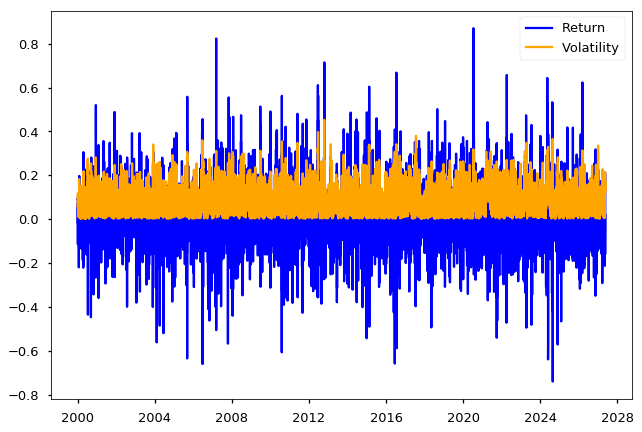

In [23]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [24]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.004079,-0.000132
rtn,-0.000132,0.012708


In [25]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

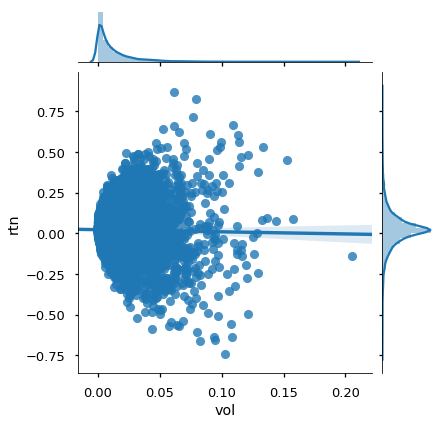

In [26]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [27]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.012990,0.020528
std,0.016922,0.112729
min,0.000010,-0.740438
25%,0.002028,-0.027189
50%,0.006826,0.020179
75%,0.017179,0.067907
max,0.205175,0.870792


## I now estimate all of the parameters

In [28]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [29]:
vl.compute_init_constants(data.vol)

{'log_both': -6.04083845254958,
 'log_scale': -5.513000173125457,
 'logit_rho': 1.4960210910533265}

In [30]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [31]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -6.030027277635904,
  'log_scale': -5.512774628233394,
  'logit_rho': 1.5033371424370454},
            log_both  log_scale  logit_rho
 log_both   0.001684   0.000275  -0.001880
 log_scale  0.000275   0.000415  -0.000173
 logit_rho -0.001880  -0.000173   0.004616)

In [32]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [33]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [34]:
estimator(data_arr[0])

({'gamma': 0.012568765010713627,
  'beta': 4.109462367371041,
  'psi': -3.589668240911585,
  'zeta': 0.8354200448536044,
  'log_both': -6.030027277635904,
  'log_scale': -5.512774628233394,
  'logit_rho': 1.5033371424370454,
  'phi': -0.41406108001130537,
  'pi': -8.083124999650517,
  'theta': 1.703189303410382},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.002109 -5.985308e-06  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000006  5.423891e-08  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.001684   0.000275  -0.001880       NaN   
 log_scale  0.000000  0.000000e+00  0.000275   0.000415  -0.000173       NaN   
 logit_rho  0.000000  0.000000e+00 -0.001880  -0.000173   0.004616       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.000190   
 pi              NaN           NaN       NaN        NaN        NaN -0.066708   
 psi       -0.001657  1.891210e-06  0.000000 

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [ ]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [ ]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

In [ ]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [ ]:
bounds

In [ ]:
true_params['pi']

In [ ]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega

In [ ]:
true_params

In [ ]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [ ]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=1000, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [ ]:
.mean()returnval

In [ ]:
np.percentile(returnval.qlr, 95)

In [ ]:
true_params['phi']

In [ ]:
returnval

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)